```python
file1 \_ |-----------------------------------|   -+-
file2 \_ |-----------------------------------|    |   training data
file3 \_ |-----------------------------------|    |        80%
file4 \_ |-----------------------------------|    |
                                                 -+-
file5 \_ |-----------------------------------|    |  validation data
file6 \_ |-----------------------------------|    |        20%
         |-----------------------------------|   -+-
```

In [1]:
import os
import glob

import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

from utils.MovingAverager import *

# 前處理

In [5]:
# df = load_original_data('../CollectedData/front_pocket/202302071652/source')
# df = load_original_data('../CollectedData/front_pocket/202302071541/target')
df = load_original_data('../CollectedData/swing/202302132124/target')
# df = load_original_data('../CollectedData/swing/202302121909/source')
# df = load_original_data('./data/', delimiter=',')

In [19]:
def calculate_z_angle(df):
    df['acc_t'] = np.sqrt((df['acc_x'] ** 2) + (df['acc_y'] ** 2) + (df['acc_z'] ** 2))
    df[['gacc_x', 'gacc_y', 'gacc_z']] = df[['acc_x', 'acc_y', 'acc_z']].to_numpy() - df[['lin_acc_x', 'lin_acc_y', 'lin_acc_z']].to_numpy()
    df['gacc_t'] = np.sqrt((df['gacc_x'] ** 2) + (df['gacc_y'] ** 2) + (df['gacc_z'] ** 2))

    acc_xyz = df[['acc_x', 'acc_y', 'acc_z']].to_numpy()
    acc_t = df['acc_t'].to_numpy()
    gacc_t = df['gacc_t'].to_numpy()
    gacc_xyz = np.concatenate((np.zeros((len(df), 2)), gacc_t[:, None]), axis=-1)

    angle = np.arccos((np.sum(acc_xyz * gacc_xyz, axis=-1)) / (acc_t *  gacc_t)) / np.pi * 180
    
    return angle

In [20]:
def calculate_y_angle(df):
    df['acc_t'] = np.sqrt((df['acc_x'] ** 2) + (df['acc_y'] ** 2) + (df['acc_z'] ** 2))
    df[['gacc_x', 'gacc_y', 'gacc_z']] = df[['acc_x', 'acc_y', 'acc_z']].to_numpy() - df[['lin_acc_x', 'lin_acc_y', 'lin_acc_z']].to_numpy()
    df['gacc_t'] = np.sqrt((df['gacc_x'] ** 2) + (df['gacc_y'] ** 2) + (df['gacc_z'] ** 2))

    acc_xyz = df[['acc_x', 'acc_y', 'acc_z']].to_numpy()
    acc_t = df['acc_t'].to_numpy()
    gacc_t = df['gacc_t'].to_numpy()
    gacc_xyz = np.concatenate((np.zeros((len(df), 1)), gacc_t[:, None], np.zeros((len(df), 1))), axis=-1)

    angle = np.arccos((np.sum(acc_xyz * gacc_xyz, axis=-1)) / (acc_t *  gacc_t)) / np.pi * 180
    
    return angle

In [9]:
def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix

In [10]:
def calculate_transformation_matrix(row):
    acc_t = np.sqrt((row['acc_x'] ** 2) + (row['acc_y'] ** 2) + (row['acc_z'] ** 2))
    gacc_x, gacc_y, gacc_z = row[['acc_x', 'acc_y', 'acc_z']].to_numpy() - row[['lin_acc_x', 'lin_acc_y', 'lin_acc_z']].to_numpy()
    gacc_t = np.sqrt((gacc_x ** 2) + (gacc_y ** 2) + (gacc_z ** 2))

    old_gacc_xyz = np.array([gacc_x, gacc_y, gacc_z])
    n_gacc = np.sqrt(2) / 2 * gacc_t
    new_gacc_xyz = np.array([0, n_gacc, n_gacc])

    transformation_matrix = rotation_matrix_from_vectors(old_gacc_xyz, new_gacc_xyz)

    return np.concatenate((transformation_matrix @ row[['acc_x', 'acc_y', 'acc_z']], transformation_matrix @ row[['lin_acc_x', 'lin_acc_y', 'lin_acc_z']], transformation_matrix @ row[['mag_x', 'mag_y', 'mag_z']]))

In [11]:
acc_t = np.sqrt((df['acc_x'] ** 2) + (df['acc_y'] ** 2) + (df['acc_z'] ** 2))
df[['gacc_x', 'gacc_y', 'gacc_z']] = df[['acc_x', 'acc_y', 'acc_z']].to_numpy() - df[['lin_acc_x', 'lin_acc_y', 'lin_acc_z']].to_numpy()
gacc_t = np.sqrt((df['gacc_x'] ** 2) + (df['gacc_y'] ** 2) + (df['gacc_z'] ** 2))

n_gacc = np.sqrt(2) / 2 * gacc_t
df['new_gacc_x'] = 0
df['new_gacc_y'] = n_gacc
df['new_gacc_z'] = n_gacc

In [12]:
gacc = df.loc[0, ['gacc_x', 'gacc_y', 'gacc_z']].to_numpy()
new_gacc = df.loc[0, ['new_gacc_x', 'new_gacc_y', 'new_gacc_z']].to_numpy()
rm = rotation_matrix_from_vectors(gacc, new_gacc)

In [13]:
rm @ gacc

array([1.80411242e-16, 7.07850939e+00, 7.07850939e+00])

# cal angle

In [14]:
df['acc_x'] = moving_average(df['acc_x'], 21)
df['acc_y'] = moving_average(df['acc_y'], 21)
df['acc_z'] = moving_average(df['acc_z'], 21)

df['lin_acc_x'] = moving_average(df['lin_acc_x'], 21)
df['lin_acc_y'] = moving_average(df['lin_acc_y'], 21)
df['lin_acc_z'] = moving_average(df['lin_acc_z'], 21)

In [15]:
# df[['new_acc_x', 'new_acc_y', 'new_acc_z']] = df.apply(lambda x: calculate_transformation_matrix(x), axis=1, result_type='expand')
df[['acc_x', 'acc_y', 'acc_z', 'lin_acc_x', 'lin_acc_y', 'lin_acc_z', 'new_x', 'new_y', 'new_z']] = df.apply(lambda x: calculate_transformation_matrix(x), axis=1, result_type='expand')

In [21]:
df['z_angle'] = calculate_z_angle(df)
df['y_angle'] = calculate_y_angle(df)
df['angle'] = df['z_angle'] + df['y_angle']

# df['mag_h'] = df['mag_t'] * np.sin(df['angle'] / 180 * np.pi)
# df['mag_v'] = df['mag_t'] * np.cos(df['angle'] / 180 * np.pi)

In [22]:
df

,acc_x,acc_y,acc_z,lin_acc_x,lin_acc_y,lin_acc_z,mag_x,mag_y,mag_z,mag_t,...,new_gacc_y,new_gacc_z,new_x,new_y,new_z,acc_t,gacc_t,angle,z_angle,y_angle
0,-0.106320,6.858879,6.937865,-0.106320,-0.053855,0.025131,45.801444,-34.656105,-10.191958,58.332615,...,7.078509,7.078509,47.036390,-34.096093,5.265779,9.756510,9.776082,44.675428,44.675428,45.331376
1,-0.053368,6.804995,6.980387,-0.053368,-0.085469,0.089923,46.014436,-34.200082,-9.707100,58.148101,...,6.509692,6.509692,46.975501,-33.939017,4.758896,9.748673,9.744589,44.271943,44.271943,45.729774
2,-0.058067,6.773854,6.980035,-0.058067,-0.113955,0.092226,46.269567,-33.614423,-9.299601,57.942082,...,7.361835,7.361835,47.192759,-33.269465,4.824008,9.726734,9.740833,44.142212,44.142212,45.859831
3,-0.064381,6.824232,6.970267,-0.064381,-0.067927,0.078109,46.477448,-33.106227,-8.976558,57.764644,...,6.398044,6.398044,47.297956,-32.866502,4.410266,9.754943,9.746984,44.394737,44.394737,45.607760
4,-0.006090,6.803726,6.986238,-0.006090,-0.114220,0.068292,46.652338,-32.684225,-8.638192,57.613519,...,7.229189,7.229189,47.385308,-32.521872,4.034605,9.751833,9.783453,44.241738,44.241738,45.758284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7056,0.063626,6.678964,7.075277,0.063626,-0.231297,0.165017,-20.960688,-41.532126,-11.198643,47.850575,...,7.026366,7.026366,-15.987568,-43.575146,11.631074,9.729962,9.772584,43.350840,43.350840,46.651614
7057,0.073807,6.683124,7.042751,0.073807,-0.208533,0.151094,-20.763631,-41.662215,-11.272628,47.895101,...,6.991474,6.991474,-15.872908,-43.706093,11.479065,9.709271,9.746275,43.500900,43.500900,46.502416
7058,0.066062,6.663890,7.021103,0.066062,-0.205861,0.151352,-20.626750,-41.765998,-11.304815,47.933915,...,7.001662,7.001662,-15.807244,-43.758154,11.533223,9.680273,9.715294,43.506182,43.506182,46.496490
7059,0.073587,6.692880,7.000346,0.073587,-0.188014,0.119452,-20.501691,-41.844502,-11.347999,47.958927,...,6.846900,6.846900,-15.764998,-43.756372,11.700574,9.685293,9.731054,43.715434,43.715434,46.287877


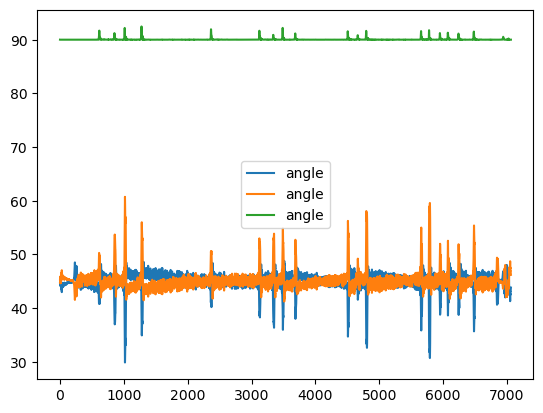

In [25]:
plt.figure()
plt.plot(np.arange(len(df)), df['z_angle'], label='angle')
plt.plot(np.arange(len(df)), df['y_angle'], label='angle')
plt.plot(np.arange(len(df)), df['angle'], label='angle')
# plt.plot(np.arange(len(df)), moving_average(df['angle'], 41), label='angle')
plt.legend()
plt.show()

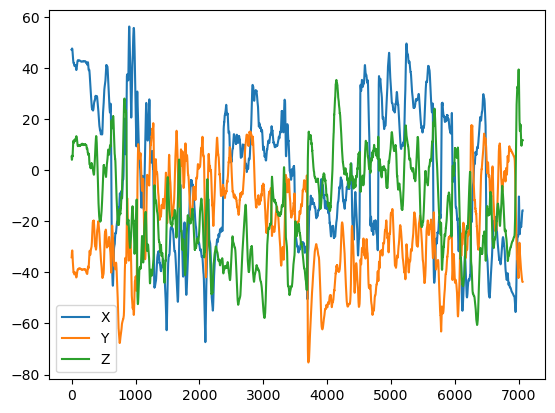

In [26]:
plt.figure()
plt.plot(np.arange(len(df)), df['new_x'], label='X')
plt.plot(np.arange(len(df)), df['new_y'], label='Y')
plt.plot(np.arange(len(df)), df['new_z'], label='Z')

plt.legend()
plt.show()

In [ ]:
def recurrsive(smag, tmag, sgyro, tgyro):
    s = [np.diag(_) for _ in smag]
    t = [np.diag(_) for _ in tmag]
    C = np.linalg.solve(s[0], t[0])
    ans = []
    for idx, gyro in enumerate(sgyro[:]):
        tmp = np.dot(C, np.array(smag[idx]))
#         tmp *= (np.sqrt(np.sum(smag[idx] ** 2)) / np.sqrt(np.sum(tmp ** 2)))
        ans.append(tmp)
        C = C @ (np.identity(3) + 0.05 * np.array([[0, -sgyro[idx][2], sgyro[idx][1]],
                                              [sgyro[idx][2], 0, -sgyro[idx][0]],
                                              [-sgyro[idx][1], sgyro[idx][0], 0]]
        ))
        
    return ans

# rotate

In [137]:
def get_rotation_matrix(angle):
    pitch = 0
    roll = angle / 180 * np.pi
    yaw = 0
    p_m = [[np.cos(pitch), 0, np.sin(pitch)], [0, 1, 0], [-np.sin(pitch), 0, np.cos(pitch)]]
    y_m = [[1, 0, 0], [0, np.cos(roll), -np.sin(roll)], [0, np.sin(roll), np.cos(roll)]]
    r_m = [[np.cos(yaw), -np.sin(yaw), 0], [np.sin(yaw), np.cos(yaw), 0], [0, 0, 1]]
    
    p_m, y_m, r_m = np.array(p_m), np.array(y_m), np.array(r_m)
    rotation_matrix = p_m @ y_m @ r_m
    
    return rotation_matrix

In [171]:
get_rotation_matrix(40)

array([[ 1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.76604444, -0.64278761],
       [ 0.        ,  0.64278761,  0.76604444]])

In [126]:
def calculate_transform(row, column_name):
    R = get_rotation_matrix(row['angle'] - 45)
    new_mag = R @ row[column_name]
    
    return new_mag

In [92]:
def calculate_new_angle(df):
    df['new_acc_t'] = np.sqrt((df['new_acc_x'] ** 2) + (df['new_acc_y'] ** 2) + (df['new_acc_z'] ** 2))
    df[['new_gacc_x', 'new_gacc_y', 'new_gacc_z']] = df[['new_acc_x', 'new_acc_y', 'new_acc_z']].to_numpy() - df[['new_lin_acc_x', 'new_lin_acc_y', 'new_lin_acc_z']].to_numpy()
    df['new_gacc_t'] = np.sqrt((df['new_gacc_x'] ** 2) + (df['new_gacc_y'] ** 2) + (df['new_gacc_z'] ** 2))

    acc_xyz = df[['new_acc_x', 'new_acc_y', 'new_acc_z']].to_numpy()
    acc_t = df['new_acc_t'].to_numpy()
    gacc_t = df['new_gacc_t'].to_numpy()
    gacc_xyz = np.concatenate((np.zeros((len(df), 2)), gacc_t[:, None]), axis=-1)

    angle = np.arccos((np.sum(acc_xyz * gacc_xyz, axis=-1)) / (acc_t *  gacc_t)) / np.pi * 180
    
    return angle

In [172]:
df[['new_acc_x', 'new_acc_y', 'new_acc_z']] = df.apply(lambda x: calculate_transform(x, ['acc_x', 'acc_y', 'acc_z']), axis=1, result_type='expand')
df[['new_lin_acc_x', 'new_lin_acc_y', 'new_lin_acc_z']] = df.apply(lambda x: calculate_transform(x, ['lin_acc_x', 'lin_acc_y', 'lin_acc_z']), axis=1, result_type='expand')

In [173]:
df['new_angle'] = calculate_new_angle(df)

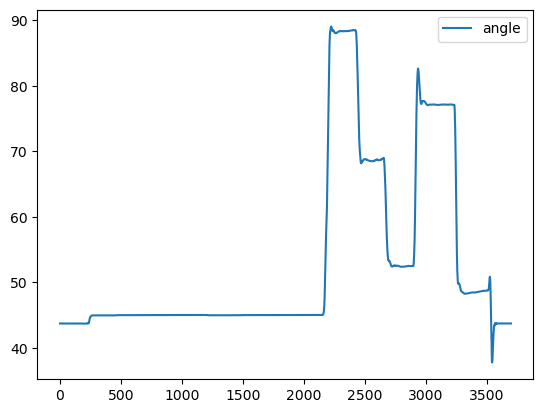

In [174]:
plt.figure()
plt.plot(np.arange(len(df)), df['new_angle'], label='angle')
# plt.plot(np.arange(len(df)), moving_average(df['new_angle'], 11), label='angle')

plt.legend()
plt.show()

In [175]:
df[['new_x', 'new_y', 'new_z']] = df.apply(lambda x: calculate_transform(x, ['mag_x', 'mag_y', 'mag_z']), axis=1, result_type='expand')

In [176]:
df

,acc_x,acc_y,acc_z,lin_acc_x,lin_acc_y,lin_acc_z,mag_x,mag_y,mag_z,mag_t,...,new_lin_acc_z,new_acc_t,new_gacc_x,new_gacc_y,new_gacc_z,new_gacc_t,new_angle,new_x,new_y,new_z
0,-0.294830,0.080245,9.900432,0.003628,0.001681,0.002532,-71.884094,-4.634659,-32.984660,79.226201,...,0.000694,9.905146,-0.298458,6.836880,7.157630,9.902710,43.723199,-71.884094,-25.969820,-20.857525
1,-0.294764,0.080281,9.900520,0.003449,0.001516,0.002617,-71.908640,-4.643182,-32.916138,79.220476,...,0.000868,9.905233,-0.298214,6.837069,7.157456,9.902708,43.723715,-71.908640,-25.929213,-20.801614
2,-0.294784,0.080558,9.900893,0.003270,0.001351,0.002702,-71.941708,-4.641477,-32.823751,79.212066,...,0.001043,9.905608,-0.298055,6.837531,7.157419,9.902995,43.724838,-71.941708,-25.864521,-20.735682
3,-0.294804,0.080637,9.901138,0.003091,0.001186,0.002787,-71.973072,-4.646591,-32.704092,79.191360,...,0.001218,9.905854,-0.297896,6.837794,7.157391,9.903152,43.725095,-71.973072,-25.786218,-20.645082
4,-0.294739,0.080772,9.901355,0.002717,0.000977,0.002601,-72.009549,-4.648296,-32.582729,79.174592,...,0.001226,9.906070,-0.297455,6.838346,7.157425,9.903544,43.726051,-72.009549,-25.704403,-20.555402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3694,-0.294354,0.078747,9.925172,-0.000434,-0.001846,-0.000154,-74.917844,4.124318,-25.032615,79.096935,...,0.001153,9.929848,-0.293920,6.858308,7.175109,9.930004,43.722479,-74.917844,-14.144784,-21.061027
3695,-0.294199,0.078673,9.925179,-0.000033,-0.001937,-0.000124,-74.900457,4.087841,-24.998183,79.067680,...,0.001237,9.929850,-0.294166,6.858428,7.174964,9.929989,43.723000,-74.900457,-14.148127,-21.010714
3696,-0.294414,0.078584,9.925300,0.000368,-0.002028,-0.000095,-74.883070,4.051364,-24.963751,79.038450,...,0.001320,9.929977,-0.294782,6.858362,7.175154,9.930099,43.721478,-74.883070,-14.150728,-20.960900
3697,-0.294202,0.078624,9.925635,0.000313,-0.002350,0.000168,-74.865683,4.014886,-24.929319,79.009245,...,0.001733,9.930305,-0.294515,6.858822,7.174817,9.930165,43.722834,-74.865683,-14.154143,-20.910535


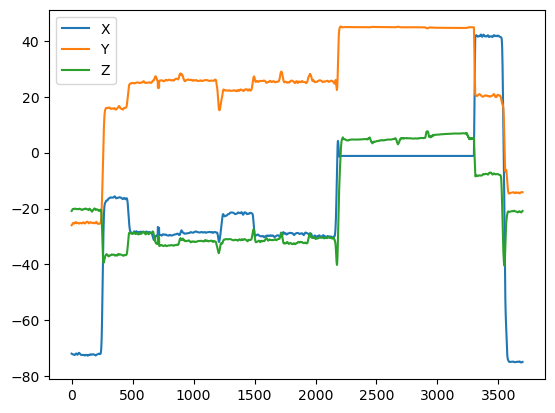

In [177]:
plt.figure()
plt.plot(np.arange(len(df)), df['new_x'], label='X')
plt.plot(np.arange(len(df)), df['new_y'], label='Y')
plt.plot(np.arange(len(df)), df['new_z'], label='Z')

plt.legend()
plt.show()

In [156]:
import matplotlib.pyplot as plt

# 讀檔

In [3]:
def rename_data(df):
    new_names = ['system_time', 'acc_times', 'acc_x', 'acc_y', 'acc_z', 'lin_acc_times', 'lin_acc_x', 'lin_acc_y', 'lin_acc_z', 'mag_times', 'mag_x', 'mag_y', 'mag_z']
    df.columns = new_names
    
    return df


def device_start_system_time(path, delimiter):
    time_df = pd.read_csv(path, delimiter=delimiter, index_col=0)
    time = time_df.T.loc['system time', 'START']
    
    return time


def gen_total_mag(df: pd.DataFrame):
    
    df['mag_x'] = moving_average(df['mag_x'], 11)
    df['mag_y'] = moving_average(df['mag_y'], 11)
    df['mag_z'] = moving_average(df['mag_z'], 11)
    
    df['mag_t'] = np.sqrt((df['mag_x'] ** 2) + (df['mag_y'] ** 2) + (df['mag_z'] ** 2))
    
    return df


def load_original_data(path, delimiter=';'):
    acc_df = pd.read_csv(os.path.join(path, 'Accelerometer.csv'), delimiter=delimiter)
#     gyo_df = pd.read_csv(os.path.join(path, 'Gyroscope.csv'), delimiter=';')
    linacc_df = pd.read_csv(os.path.join(path, 'Linear Accelerometer.csv'), delimiter=delimiter)
    mag_df = pd.read_csv(os.path.join(path, 'Magnetometer.csv'), delimiter=delimiter)
    start_time = device_start_system_time(os.path.join(path, 'meta/time.csv'), delimiter)
    time_df = acc_df.iloc[:, 0] + start_time
    
    total_df = pd.concat([time_df, acc_df, linacc_df, mag_df], axis=1)
    total_df = total_df[:-5]  # remove last None value row
    total_df = rename_data(total_df)
    total_df = gen_total_mag(total_df)
    total_df = total_df[['acc_x', 'acc_y', 'acc_z', 'lin_acc_x', 'lin_acc_y', 'lin_acc_z', 'mag_x', 'mag_y', 'mag_z', 'mag_t', 'system_time']]
    
    return total_df

In [4]:
def align_data(source_df, target_df):
    source_start_time = source_df.loc[0, 'system_time']
    target_start_time = target_df.loc[0, 'system_time']
    
    # align start time
    if source_start_time > target_start_time:  # source start time > target start time
        target_start_idx = np.argmin(np.abs(target_df.system_time - source_start_time))
        target_df = target_df.iloc[target_start_idx:].reset_index(drop=True)
    else:  # source start time < target start time
        source_start_idx = np.argmin(np.abs(source_df.system_time - target_start_time))
        source_df = source_df.iloc[source_start_idx:].reset_index(drop=True)
        
    # align end idx
    end_idx = min(len(source_df), len(target_df))
    source_df = source_df.iloc[:end_idx]
    target_df = target_df.iloc[:end_idx]
    
    return source_df, target_df


def bound_range(df):
    start = datapoint_per_second * 35
    end = len(df) - datapoint_per_second * 20
    
    return df.iloc[start:end].reset_index(drop=True)


def split_segments(df, seq_len=25):
    num_of_segs = int(np.floor(len(df) / seq_len))
    
    segments = []
    for i in range(num_of_segs):
        seg = df.iloc[int(i * seq_len):int((i + 1) * seq_len)].to_numpy()
        segments.append(seg)
        
    return segments


def split_segments_overlap(df, seq_len=25, shift=15):
    
    segments = []
    for i in range(0, len(df) - seq_len, shift):
        seg = df.iloc[i:i + seq_len].to_numpy()
        segments.append(seg)
        
    return segments


def select_data(df):
    return df[['lin_acc_x', 'lin_acc_y', 'lin_acc_z', 'gyo_x', 'gyo_y', 'gyo_z', 'mag_x', 'mag_y', 'mag_z', 'mag_t', 'system_time']]


def preprocess_data(df, seq_len=25, shift=15, is_train_data=False):
    pre_df = select_data(df)
    
    if is_train_data:
        segs = split_segments_overlap(pre_df, seq_len, shift)
    else:
        segs = split_segments(pre_df, seq_len)
    
    return segs

In [4]:
def device_version(path):
    device_df = pd.read_csv(path, delimiter=';', index_col=0)
    version = device_df.loc['deviceRelease'].value
    
    return version


def check_data_device(source_path, target_path):
    while True:
        source_version = device_version(os.path.join(source_path, 'meta/device.csv'))
        target_version = device_version(os.path.join(target_path, 'meta/device.csv'))

#         print(source_path, target_path)

        if source_version[:2] == '15' and target_version[:2] == '16':
            return source_path, target_path
        elif source_version[:2] == '16' and target_version[:2] == '15':
            source_path = os.path.join(folder_path, 'target')
            target_path = os.path.join(folder_path, 'source')
            print('--- GG ---')
            continue
        else:
            raise


def load_pair_data(root_folder, class_num, file_index=None, is_train_data=False):
    prefix = 'train' if is_train_data else 'valid'
    pair_data = []
    folder_paths = glob.glob(f'*{os.path.normpath(root_folder)}/*')

    if file_index is not None:
        folder_paths = folder_paths[file_index[0]:file_index[1]]

    for i, folder_path in enumerate(folder_paths):
        source_path = os.path.join(folder_path, 'source')
        target_path = os.path.join(folder_path, 'target')
        
        print(f'{prefix} {i + 1: >3}: {folder_path}')
        
        #########################
        ##### check devices #####
        #########################
        source_path, target_path = check_data_device(source_path, target_path)
        
        ####################################
        ##### load and preprocess data #####
        ####################################
        source_df = load_original_data(source_path)
        target_df = load_original_data(target_path)
        
#         print(source_df.system_time[0], target_df.system_time[0])
        
        source_df, target_df = bound_range(source_df), bound_range(target_df)
        source_df, target_df = align_data(source_df, target_df)

        source_segs = preprocess_data(source_df, seq_len, shift, is_train_data)
        target_segs = preprocess_data(target_df, seq_len, shift, is_train_data)
        
        idx = min(len(source_segs), len(target_segs))
        source_tags = [class_num] * idx
        target_tags = [0] * idx
        
        pair_data.extend(zip(source_segs[:idx], source_tags, target_segs[:idx], target_tags))
        
    return pair_data